In [1]:
!pip install scikit-optimize
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 16.5 MB/s eta 0:00:00


Setting up all the imports for the Bayesian Optimization

In [31]:
import os, zipfile, json, time
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import logit, expit
from scipy.sparse import hstack
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from skopt.callbacks import DeadlineStopper
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.pipeline import Pipeline
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import joblib

Configuring the constants - setting the right dataset files, timeout and seed.

In [53]:
ZIP20_MITRE = "CVES_2020.zip"
ZIP20_NVD   = "nvdcve-1.1-2020.zip"
ZIP21_MITRE = "CVES_2021.zip"
ZIP21_NVD   = "nvdcve-1.1-2021.zip"
ZIP22_MITRE = "CVES_2022.zip"
ZIP22_NVD   = "nvdcve-1.1-2022.zip"
ZIP23_MITRE = "CVES_2023.zip"
ZIP23_NVD   = "nvdcve-1.1-2023.zip"
ZIP24_MITRE = "CVES_2024.zip"
ZIP24_NVD   = "nvdcve-1.1-2024.zip"

EPSS_PATH = "epss_scores-2025-05-04.csv.gz"
SNAP_DATE = pd.Timestamp("2023-12-31", tz="UTC")
SEED      = 45
TIMEOUT   = 3600         # seconds for bayes search
WORST_FRAC= 0.05         # top 5% highest‐EPSS CVEs

# ensure all required files are present
for p in (ZIP20_MITRE, ZIP20_NVD, ZIP21_MITRE, ZIP21_NVD, ZIP22_MITRE, ZIP22_NVD,
          ZIP23_MITRE, ZIP23_NVD, ZIP24_MITRE, ZIP24_NVD, EPSS_PATH):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing file: {p}")

global_start = time.perf_counter()

Setting up the EPSS

In [54]:
t0 = time.perf_counter()
epss_all = pd.read_csv(
    EPSS_PATH,
    compression="gzip",
    skiprows=2,
    header=None,
    names=["cve","epss","percentile"]
)[["cve","epss"]]
t1 = time.perf_counter()
print(f"[1] EPSS loaded ({len(epss_all)} rows) in {t1-t0:.1f}s")

[1] EPSS loaded (277382 rows) in 0.3s


Helper function for loading the CVES and joining the EPSS scores

In [55]:
def load_cves(mitre_zip_path, nvd_zip_path, epss_df):
    recs = []

    # Step 1: List MITRE ZIP contents (debug)
    with zipfile.ZipFile(mitre_zip_path) as mitre_zip:
        names = mitre_zip.namelist()
        print(f"[DEBUG] ZIP content in {mitre_zip_path} — total files: {len(names)}")
        for fn in names[:20]:
            print(f" - {fn}")

    # Step 2: Load NVD JSON from ZIP
    with zipfile.ZipFile(nvd_zip_path) as nvd_zip:
        with nvd_zip.open(nvd_zip.namelist()[0]) as f:
            nvd_data = json.load(f)
            nvd_lookup = {
                item["cve"]["CVE_data_meta"]["ID"]: item
                for item in nvd_data["CVE_Items"]
            }

    # Step 3: Iterate over MITRE JSON files inside the ZIP
    with zipfile.ZipFile(mitre_zip_path) as mitre_zip:
        for fn in mitre_zip.namelist():
            # Skip non-json and __MACOSX files
            if not fn.endswith(".json") or "__MACOSX" in fn:
                continue

            try:
                r = json.load(mitre_zip.open(fn))
                m = r.get("cveMetadata", {})
                pub = m.get("datePublished", "")
                if not pub:
                    continue

                dt = pd.to_datetime(pub, utc=True)
                cid = m.get("cveId", "")
                if not cid:
                    print(f"[WARN] No CVE ID in {fn}")
                    continue

                cna = r.get("containers", {}).get("cna", {})
                descs = cna.get("descriptions", [])
                desc = descs[0]["value"] if descs else ""
                refs = cna.get("references", [])
                ptypes = cna.get("problemTypes", [])

                # Add NVD info if available
                nvd = nvd_lookup.get(cid, {})
                impact = nvd.get("impact", {})
                cvss_v3 = impact.get("baseMetricV3", {}).get("cvssV3", {})
                score = cvss_v3.get("baseScore", None)
                severity = cvss_v3.get("baseSeverity", None)

                recs.append({
                    "cve": cid,
                    "pub_dt": dt,
                    "year": dt.year,
                    "desc": desc,
                    "desc_length": len(desc),
                    "ref_count": len(refs),
                    "cwe_count": sum(len(pt.get("descriptions", [])) for pt in ptypes),
                    "cvss_score": score,
                    "cvss_severity": severity,
                })

            except Exception as e:
                print(f"[ERROR] Failed to parse {fn}: {e}")

    print(f"[DEBUG] Loaded {len(recs)} CVEs from {mitre_zip_path}")
    df = pd.DataFrame(recs)

    if df.empty:
        print("[WARN] No CVEs collected — returning empty DataFrame")
        return pd.DataFrame()

    df_merged = df.merge(epss_df, on="cve", how="inner")
    print(f"[DEBUG] After EPSs merge: {len(df_merged)} records remain")
    return df_merged

Load 2021, 2022, 2023 → downsample 15k/yr → 45k → 80/20 train/val

In [56]:
t0 = time.perf_counter()
# load each year
df20 = load_cves(ZIP20_MITRE, ZIP20_NVD, epss_all)
df21 = load_cves(ZIP21_MITRE, ZIP21_NVD, epss_all)
df22 = load_cves(ZIP22_MITRE, ZIP22_NVD, epss_all)
df23 = load_cves(ZIP23_MITRE, ZIP23_NVD, epss_all)

# sample 15k from each year
sample20 = df20.sample(15000, random_state=SEED)
sample21 = df21.sample(15000, random_state=SEED)
sample22 = df22.sample(15000, random_state=SEED)
sample23 = df23.sample(15000, random_state=SEED)

# concatenate and split
df_trainval = pd.concat([sample20, sample21, sample22, sample23], ignore_index=True)
df_train, df_val = train_test_split(
    df_trainval, test_size=0.20, random_state=SEED
)
t1 = time.perf_counter()
print(f"[2] 21–23 split ▶ train={len(df_train)}, val={len(df_val)} in {t1-t0:.1f}s")

[DEBUG] ZIP content in CVES_2020.zip — total files: 20634
 - 2020/
 - 2020/0xxx/
 - 2020/0xxx/CVE-2020-0001.json
 - 2020/0xxx/CVE-2020-0002.json
 - 2020/0xxx/CVE-2020-0003.json
 - 2020/0xxx/CVE-2020-0004.json
 - 2020/0xxx/CVE-2020-0005.json
 - 2020/0xxx/CVE-2020-0006.json
 - 2020/0xxx/CVE-2020-0007.json
 - 2020/0xxx/CVE-2020-0008.json
 - 2020/0xxx/CVE-2020-0009.json
 - 2020/0xxx/CVE-2020-0010.json
 - 2020/0xxx/CVE-2020-0011.json
 - 2020/0xxx/CVE-2020-0012.json
 - 2020/0xxx/CVE-2020-0014.json
 - 2020/0xxx/CVE-2020-0015.json
 - 2020/0xxx/CVE-2020-0016.json
 - 2020/0xxx/CVE-2020-0017.json
 - 2020/0xxx/CVE-2020-0018.json
 - 2020/0xxx/CVE-2020-0019.json
[DEBUG] Loaded 20231 CVEs from CVES_2020.zip
[DEBUG] After EPSs merge: 18969 records remain
[DEBUG] ZIP content in CVES_2021.zip — total files: 19596
 - CVES_2021/
 - CVES_2021/2021/
 - CVES_2021/2021/0xxx/
 - CVES_2021/2021/0xxx/CVE-2021-0001.json
 - CVES_2021/2021/0xxx/CVE-2021-0002.json
 - CVES_2021/2021/0xxx/CVE-2021-0003.json
 - CVES_20

Load 2024 → sample exactly 6k (20% of 30k) for test

In [58]:
t0 = time.perf_counter()
df24 = load_cves(ZIP24_MITRE, ZIP24_NVD, epss_all)
n_test = int(len(df_trainval) * 0.20)
df_test = df24.sample(n=n_test, random_state=SEED)
t1 = time.perf_counter()
print(f"[3] 2024 sample ▶ test={len(df_test)} in {t1-t0:.1f}s")


[DEBUG] ZIP content in CVES_2024.zip — total files: 37796
 - CVES_2024/
 - CVES_2024/2024/
 - CVES_2024/2024/0xxx/
 - CVES_2024/2024/0xxx/CVE-2024-0001.json
 - CVES_2024/2024/0xxx/CVE-2024-0002.json
 - CVES_2024/2024/0xxx/CVE-2024-0003.json
 - CVES_2024/2024/0xxx/CVE-2024-0004.json
 - CVES_2024/2024/0xxx/CVE-2024-0005.json
 - CVES_2024/2024/0xxx/CVE-2024-0006.json
 - CVES_2024/2024/0xxx/CVE-2024-0007.json
 - CVES_2024/2024/0xxx/CVE-2024-0008.json
 - CVES_2024/2024/0xxx/CVE-2024-0009.json
 - CVES_2024/2024/0xxx/CVE-2024-0010.json
 - CVES_2024/2024/0xxx/CVE-2024-0011.json
 - CVES_2024/2024/0xxx/CVE-2024-0012.json
 - CVES_2024/2024/0xxx/CVE-2024-0014.json
 - CVES_2024/2024/0xxx/CVE-2024-0015.json
 - CVES_2024/2024/0xxx/CVE-2024-0016.json
 - CVES_2024/2024/0xxx/CVE-2024-0017.json
 - CVES_2024/2024/0xxx/CVE-2024-0018.json
[DEBUG] Loaded 37351 CVEs from CVES_2024.zip
[DEBUG] After EPSs merge: 37082 records remain
[3] 2024 sample ▶ test=12000 in 41.5s


Feature Engineering

In [59]:
t0 = time.perf_counter()
for d in (df_train, df_val, df_test):
    d["days_since"] = (SNAP_DATE - d["pub_dt"]).dt.days

tfidf = TfidfVectorizer(max_features=100, stop_words="english")
tfidf.fit(df_train["desc"])
joblib.dump(tfidf, "tfidf_reg_bayes_tamed_timed.joblib")

num_cols = ["year","desc_length","ref_count","cwe_count","days_since"]
def build_X_y(df):
    Xn = df[num_cols].values
    Xt = tfidf.transform(df["desc"])
    X  = hstack([Xn, Xt])
    y  = logit(df["epss"].clip(1e-6, 1-1e-6))
    return X, y

X_tr, y_tr   = build_X_y(df_train)
X_val, y_val = build_X_y(df_val)
X_te, y_te   = build_X_y(df_test)

scaler = StandardScaler(with_mean=False).fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_val_s= scaler.transform(X_val)
X_te_s = scaler.transform(X_te)
joblib.dump(scaler, "scaler_reg_bayes_tamed_timed.joblib")
t1 = time.perf_counter()
print(f"[4] Featurization + scaling in {t1-t0:.1f}s")

[4] Featurization + scaling in 4.9s


Bayesian Optimization with 1h timeout

In [ ]:
search_spaces = {
    "max_depth":         Integer(2, 6),              # Conservative tree depth
    "learning_rate":     Real(0.1, 0.5, prior="uniform"),  # Stable learning rate
    "gamma":             Real(0, 5, prior="uniform"),       # Min loss reduction
    "reg_lambda":        Real(0, 5, prior="uniform"),       # L2 regularization
    "reg_alpha":         Real(0, 2, prior="uniform"),       # L1 regularization
    "subsample":         Real(0.7, 1.0, prior="uniform"),   # Row sampling
    "colsample_bytree":  Real(0.7, 1.0, prior="uniform")    # Feature sampling
}

bayes = BayesSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=SEED),
    search_spaces=search_spaces,
    n_iter=50, cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1, random_state=SEED,
    verbose=0, return_train_score=True
)

stopper = DeadlineStopper(total_time=TIMEOUT)

print("[5] Starting BayesSearchCV (timeout 1 h)...")
t2 = time.perf_counter()
bayes.fit(X_tr_s, y_tr, callback=[stopper])
t3 = time.perf_counter()
print(f"[5] BayesSearchCV done in {t3-t2:.1f}s; best_params={bayes.best_params_}")

model = bayes.best_estimator_

[5] Starting BayesSearchCV (timeout 1 h)...


Evaluate and write results

In [17]:
with open("results.txt","w") as out:
    out.write(f"Best params: {bayes.best_params_}\n\n")
    def report(name, Xs, ys, df_=None):
        y_log = model.predict(Xs)
        y_pred= expit(y_log)
        y_true= expit(ys)
        mse   = mean_squared_error(y_true, y_pred)
        rmse  = np.sqrt(mse)
        mae   = mean_absolute_error(y_true, y_pred)
        r2    = r2_score(y_true, y_pred)
        out.write(f"{name:5s} → MSE={mse:.6f}, RMSE={rmse:.6f}, "
                  f"MAE={mae:.6f}, R²={r2:.3f}\n")
        print(f"{name:5s} → MSE={mse:.6f}, RMSE={rmse:.6f}, "
              f"MAE={mae:.6f}, R²={r2:.3f}")
        if df_ is not None:
            df_ = df_.copy()
            df_["pred"] = y_pred
            df_["actual"] = y_true
            # mean difference actual - predicted
            mean_diff = np.mean(df_["actual"] - df_["pred"])
            out.write(f"       Mean(actual−pred) = {mean_diff:.6f}\n")
            print(f"       Mean(actual−pred) = {mean_diff:.6f}\n")

    out.write("—— Overall performance ——\n")
    print("\n[6] Overall performance:")
    report("TRAIN", X_tr_s, y_tr)
    report("VAL",   X_val_s, y_val)
    report("TEST",  X_te_s, y_te,   df_test)

    # Evaluate calibration, ranking, and top-K precision
    y_true = expit(y_te)
    y_pred = expit(model.predict(X_te_s))

    # — Calibration curve
    from sklearn.calibration import calibration_curve

    def plot_calibration(y_true, y_pred, n_bins=10, threshold=0.01):
        y_true_binary = (y_true >= threshold).astype(int)

        prob_true, prob_pred = calibration_curve(
            y_true_binary, y_pred, n_bins=n_bins, strategy='uniform'
        )

        plt.figure(figsize=(6, 6))
        plt.plot(prob_pred, prob_true, marker='o', label="Model")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect calibration")
        plt.xlabel("Mean predicted probability")
        plt.ylabel("Fraction of positives")
        plt.title(f"Calibration Plot (threshold={threshold})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig("calibration_plot.png")
        plt.close()

    plot_calibration(y_true, y_pred)

    # — Brier Score (probabilistic accuracy)
    from sklearn.metrics import brier_score_loss

    # Binarize y_true for probabilistic classification evaluation
    threshold = 0.01  # or 0.01 or something lower, depending on your EPSS threshold
    y_true_bin = (y_true >= threshold).astype(int)

    brier = brier_score_loss(y_true_bin, y_pred)

    print(f"Brier score: {brier:.6f}")
    with open("results.txt", "a") as out:
      out.write(f"Brier score: {brier:.6f}\n")

    from sklearn.metrics import average_precision_score

    ap = average_precision_score(y_true_bin, y_pred)
    print(f"Avg Precision (PR AUC): {ap:.3f}")
    with open("results.txt", "a") as out:
        out.write(f"Avg Precision (PR AUC): {ap:.3f}\n")


    from scipy.stats import spearmanr

    rho, _ = spearmanr(y_true, y_pred)
    print(f"Spearman correlation: {rho:.3f}")
    with open("results.txt", "a") as out:
        out.write(f"Spearman correlation: {rho:.3f}\n")

    def precision_at_k(y_true, y_pred, k=100):
      top_k_true = set(np.argsort(y_true)[-k:])
      top_k_pred = set(np.argsort(y_pred)[-k:])
      return len(top_k_true & top_k_pred) / k

    p_at_100 = precision_at_k(y_true, y_pred, k=100)
    print(f"Precision@100: {p_at_100:.3f}")
    with open("results.txt", "a") as out:
        out.write(f"Precision@100: {p_at_100:.3f}\n")

        # worst‐subset
        out.write("\n—— Worst‐CVEs (top 5 %) ——\n")
        print("[7] Worst‐CVEs (top 5 %):")
        df_test2 = df_test.copy()
        df_test2["pred"]   = expit(model.predict(X_te_s))
        df_test2["actual"] = df_test2["epss"]
        worst_n = int(len(df_test2) * WORST_FRAC)

        # Sort by true and predicted EPSS scores
        true_top_idx = set(df_test2.nlargest(worst_n, "actual").index)
        pred_top_idx = set(df_test2.nlargest(worst_n, "pred").index)

        # Compute true/false positives
        hits = true_top_idx & pred_top_idx
        precision = len(hits) / worst_n
        recall    = len(hits) / worst_n
        f1 = 2 * precision * recall / (precision + recall + 1e-10)  # avoid zero-division

        # Also compute regression errors on actual top-5% (as before)
        worst = df_test2.loc[list(true_top_idx)]
        y_t = worst["actual"].values
        y_p = worst["pred"].values
        mse_w  = mean_squared_error(y_t, y_p)
        rmse_w = np.sqrt(mse_w)
        mae_w  = mean_absolute_error(y_t, y_p)
        r2_w   = r2_score(y_t, y_p)

    # Log
    with open("results.txt", "a") as out:
        out.write("\n—— Worst‐CVEs (top 5 %) ——\n")
        out.write(f"WORST → n={worst_n}, MSE={mse_w:.6f}, RMSE={rmse_w:.6f}, "
                  f"MAE={mae_w:.6f}, R²={r2_w:.3f}\n")
        out.write(f"       Precision@5% = {precision:.3f}, Recall@5% = {recall:.3f}, F1@5% = {f1:.3f}\n")

    print("[7] Worst‐CVEs (top 5 %):")
    print(f"WORST → n={worst_n}, MSE={mse_w:.6f}, RMSE={rmse_w:.6f}, "
          f"MAE={mae_w:.6f}, R²={r2_w:.3f}")
    print(f"       Precision@5% = {precision:.3f}, Recall@5% = {recall:.3f}, F1@5% = {f1:.3f}")


[6] Overall performance:
TRAIN → MSE=0.012480, RMSE=0.111715, MAE=0.023605, R²=0.178
VAL   → MSE=0.012904, RMSE=0.113597, MAE=0.024260, R²=0.070
TEST  → MSE=0.007501, RMSE=0.086610, MAE=0.014108, R²=0.021
       Mean(actual−pred) = 0.011309

Brier score: 0.076268
Avg Precision (PR AUC): 0.369
Spearman correlation: 0.453
Precision@100: 0.160
[7] Worst‐CVEs (top 5 %):
[7] Worst‐CVEs (top 5 %):
WORST → n=450, MSE=0.149036, RMSE=0.386051, MAE=0.244304, R²=-0.620
       Precision@5% = 0.278, Recall@5% = 0.278, F1@5% = 0.278


RMSE Learning curve

In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("reg",    model)
])
train_sizes, train_mse, val_mse = learning_curve(
    pipe, X_tr_s, y_tr,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1,1.0,10),
    shuffle=True,
    random_state=SEED,
    n_jobs=-1
)
train_rmse = np.sqrt(-train_mse.mean(axis=1))
val_rmse   = np.sqrt(-val_mse.mean(axis=1))

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_rmse, label="Train RMSE")
plt.plot(train_sizes, val_rmse,   label="Val RMSE")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.title("Learning Curve (Tamed Bayes)")
plt.legend()
plt.tight_layout()
plt.savefig("learning_curve.png")
plt.close()

y_true = expit(y_te)
y_pred = expit(model.predict(X_te_s))
residuals = y_true - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_true, residuals, alpha=0.3, edgecolor="none")
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("True EPSS")
plt.ylabel("Residual (true − pred)")
plt.title("Residuals on Test Set")
plt.tight_layout()
plt.savefig("residuals.png")
plt.close()

global_end = time.perf_counter()
print(f"[8] Done. Total runtime: {global_end-global_start:.1f}s")

[8] Done. Total runtime: 3614.7s


Run the following to plot the Learning Curve graph and the Residuals Graph

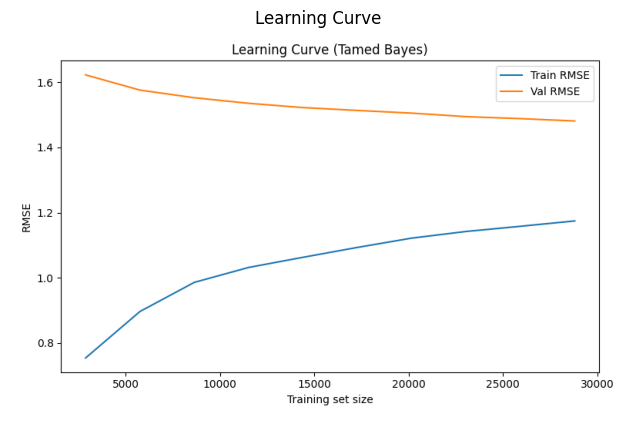

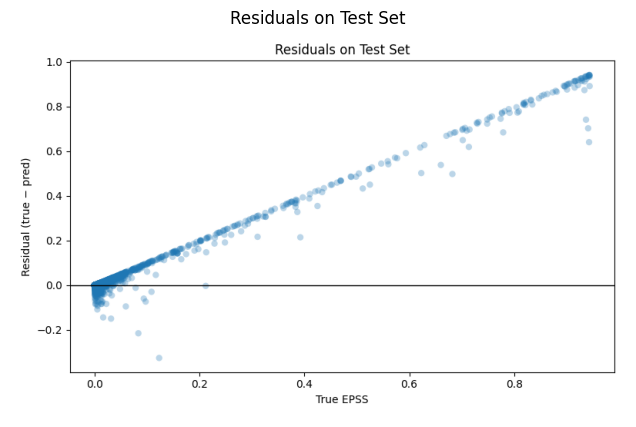

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1) Show learning curve
lc = mpimg.imread("learning_curve.png")
plt.figure(figsize=(8,5))
plt.imshow(lc)
plt.axis("off")
plt.title("Learning Curve")
plt.show()

# 2) Show residuals
res = mpimg.imread("residuals.png")
plt.figure(figsize=(8,5))
plt.imshow(res)
plt.axis("off")
plt.title("Residuals on Test Set")
plt.show()

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_true_bin, y_pred)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f"PR curve (AP = {ap:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_curve.png")
plt.close()
plt.show()


Setup imports

In [ ]:
import os, zipfile, json, time
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, learning_curve, ParameterGrid, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.special import logit, expit
from scipy.sparse import hstack
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import joblib

Setup Constants

In [ ]:
ZIP21     = "CVES_2021.zip"
ZIP23     = "CVES_2022-2023.zip"
ZIP24     = "CVES_2024.zip"
EPSS_PATH = "epss_scores-2025-05-04.csv.gz"
SNAP_DATE = pd.Timestamp("2023-12-31", tz="UTC")
SEED      = 42
TIMEOUT   = 3600         # seconds for bayes search
WORST_FRAC= 0.05         # top 5% highest‐EPSS CVEs

# ensure all required files are present
for p in (ZIP21, ZIP23, ZIP24, EPSS_PATH):
    if not os.path.isfile(p):
        raise FileNotFoundError(f"Missing file: {p}")

global_start = time.perf_counter()

Load EPSS table

In [ ]:
t0 = time.perf_counter()
epss_all = pd.read_csv(
    EPSS_PATH,
    compression="gzip",
    skiprows=2,
    header=None,
    names=["cve","epss","percentile"]
)[["cve","epss"]]
t1 = time.perf_counter()
print(f"[1] EPSS loaded ({len(epss_all)} rows) in {t1-t0:.1f}s")

[1] EPSS loaded (277382 rows) in 0.2s


Helper to Load CVEs + setup EPSS

In [ ]:
def load_cves(zip_path):
    recs = []
    with zipfile.ZipFile(zip_path) as z:
        for fn in z.namelist():
            if not fn.endswith(".json"):
                continue
            r = json.load(z.open(fn))
            m = r.get("cveMetadata",{})
            pub = m.get("datePublished","")
            if not pub: continue
            dt  = pd.to_datetime(pub, utc=True)
            cid = m["cveId"]
            cna = r["containers"]["cna"]
            descs = cna.get("descriptions",[])
            desc  = descs[0]["value"] if descs else ""
            refs  = cna.get("references",[])
            ptypes= cna.get("problemTypes",[])
            recs.append({
                "cve": cid,
                "pub_dt": dt,
                "year": dt.year,
                "desc": desc,
                "desc_length": len(desc),
                "ref_count":   len(refs),
                "cwe_count":   sum(len(pt.get("descriptions",[])) for pt in ptypes)
            })
    df = pd.DataFrame(recs)
    return df.merge(epss_all, on="cve", how="inner")

Build 2021, 2022, 2023 → 45k → 80/20 train/val

In [ ]:
t0 = time.perf_counter()
# load each year
df21 = load_cves(ZIP21)
df23 = load_cves(ZIP23)  # includes 2022 & 2023
# sample 15k from each year
sample21 = df21.sample(15000, random_state=SEED)
sample22 = df23[df23.year == 2022].sample(15000, random_state=SEED)
sample23 = df23[df23.year == 2023].sample(15000, random_state=SEED)
# combine and split
trainval = pd.concat([sample21, sample22, sample23], ignore_index=True)
df_train, df_val = train_test_split(
    trainval, test_size=0.20, random_state=SEED
)
t1 = time.perf_counter()
print(f"[2] 21–23 split ▶ train={len(df_train)}, val={len(df_val)} in {t1-t0:.1f}s")

[2] 21–23 split ▶ train=36000, val=9000 in 38.6s


Build 2024 → sample 9k test

In [ ]:
t0 = time.perf_counter()
df24   = load_cves(ZIP24)
n_test = int(len(df_trainval) * 0.20)  # 20% of 45k = 9k
# sample from 2024 only
df_test = df24.sample(n=n_test, random_state=SEED)
t1 = time.perf_counter()
print(f"[3] 2024 sample ▶ test={len(df_test)} in {t1-t0:.1f}s")

[3] 2024 sample ▶ test=9000 in 20.6s


Feature Engineering

In [ ]:
t0 = time.perf_counter()
for df in (df_train, df_val, df_test):
    df["days_since"] = (SNAP_DATE - df["pub_dt"]).dt.days

tfidf = TfidfVectorizer(max_features=100, stop_words="english")
tfidf.fit(df_train["desc"])
joblib.dump(tfidf, "tfidf_grid.pkl")

num_cols = ["year","desc_length","ref_count","cwe_count","days_since"]
def build_X_y(df):
    Xn = df[num_cols].values
    Xt = tfidf.transform(df["desc"])
    X  = hstack([Xn, Xt])
    y  = logit(df["epss"].clip(1e-6, 1-1e-6))
    return X, y

X_tr, y_tr   = build_X_y(df_train)
X_val, y_val = build_X_y(df_val)
X_te, y_te   = build_X_y(df_test)

scaler = StandardScaler(with_mean=False).fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_val_s= scaler.transform(X_val)
X_te_s = scaler.transform(X_te)
joblib.dump(scaler, "scaler_grid.pkl")
t1 = time.perf_counter()
print(f"[5] Featurized + scaled in {t1-t0:.1f}s")

[5] Featurized + scaled in 2.5s


Manual Grid-Search with 1h timeout

In [ ]:
param_grid = {
    "max_depth": [3, 4, 5, 6, 7, 8],                # 6 values
    "learning_rate": [0.01, 0.02, 0.03, 0.05,
                      0.07, 0.1]                   # 6 values
}


print("[6] Starting manual grid search with 1 h timeout…")
start_grid = time.time()
best_score  = -np.inf
best_params = None
grid_list   = list(ParameterGrid(param_grid))
n_total     = len(grid_list)

for idx, params in enumerate(grid_list, start=1):
    elapsed = time.time() - start_grid
    if elapsed > TIMEOUT:
        print(f"    ⏱ Time limit reached ({elapsed:.0f}s); stopping grid search.")
        break

    model_tmp = XGBRegressor(objective="reg:squarederror", random_state=SEED, **params)
    scores    = cross_val_score(
        model_tmp,
        X_tr_s, y_tr,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )
    mean_score = np.mean(scores)
    print(f"    {idx:4d}/{n_total:4d}  params={params}  → mean neg_MSE={mean_score:.4f}  (elapsed {elapsed:.0f}s)")

    if mean_score > best_score:
        best_score  = mean_score
        best_params = params

print(f"[6] Manual grid search done in {time.time()-start_grid:.0f}s; best_params={best_params}")

model = XGBRegressor(objective="reg:squarederror", random_state=SEED, **best_params)
model.fit(X_tr_s, y_tr)

[6] Starting manual grid search with 1 h timeout…
       1/  36  params={'learning_rate': 0.01, 'max_depth': 3}  → mean neg_MSE=-3.0760  (elapsed 0s)
       2/  36  params={'learning_rate': 0.01, 'max_depth': 4}  → mean neg_MSE=-2.9705  (elapsed 6s)
       3/  36  params={'learning_rate': 0.01, 'max_depth': 5}  → mean neg_MSE=-2.8769  (elapsed 12s)
       4/  36  params={'learning_rate': 0.01, 'max_depth': 6}  → mean neg_MSE=-2.8014  (elapsed 25s)
       5/  36  params={'learning_rate': 0.01, 'max_depth': 7}  → mean neg_MSE=-2.7360  (elapsed 45s)
       6/  36  params={'learning_rate': 0.01, 'max_depth': 8}  → mean neg_MSE=-2.6891  (elapsed 78s)
       7/  36  params={'learning_rate': 0.02, 'max_depth': 3}  → mean neg_MSE=-2.8339  (elapsed 129s)
       8/  36  params={'learning_rate': 0.02, 'max_depth': 4}  → mean neg_MSE=-2.7108  (elapsed 133s)
       9/  36  params={'learning_rate': 0.02, 'max_depth': 5}  → mean neg_MSE=-2.6120  (elapsed 140s)
      10/  36  params={'learning_rate': 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Evaluate and write results

In [ ]:
with open("results_grid.txt","w") as out:
    out.write(f"Best params: {best_params}\n\n")
    def report(name, Xs, ys, df_=None):
        y_log = model.predict(Xs)
        y_pred= expit(y_log)
        y_true= expit(ys)
        mse   = mean_squared_error(y_true, y_pred)
        rmse  = np.sqrt(mse)
        mae   = mean_absolute_error(y_true, y_pred)
        r2    = r2_score(y_true, y_pred)
        out.write(f"{name:5s} → MSE={mse:.6f}, RMSE={rmse:.6f}, "
                  f"MAE={mae:.6f}, R²={r2:.3f}\n")
        print(f"{name:5s} → MSE={mse:.6f}, RMSE={rmse:.6f}, "
              f"MAE={mae:.6f}, R²={r2:.3f}")
        if df_ is not None:
            df_ = df_.copy()
            df_["pred"]   = y_pred
            df_["actual"] = y_true
            mdiff = np.mean(df_["actual"] - df_["pred"])
            out.write(f"       Mean(actual−pred) = {mdiff:.6f}\n")
            print(f"       Mean(actual−pred) = {mdiff:.6f}\n")

    out.write("—— Overall performance ——\n")
    print("\n[7] Overall performance:")
    report("TRAIN", X_tr_s, y_tr)
    report("VAL",   X_val_s, y_val)
    report("TEST",  X_te_s, y_te, df_test)

    out.write("\n—— Worst‐CVEs (top 5 %) ——\n")
    print("[8] Worst‐CVEs (top 5 %):")
    df2 = df_test.copy()
    df2["pred"]   = expit(model.predict(X_te_s))
    df2["actual"] = df2["epss"]
    n_worst = int(len(df2)*WORST_FRAC)
    worst   = df2.nlargest(n_worst, "actual")
    y_t = worst["actual"].values
    y_p = worst["pred"].values
    mse_w  = mean_squared_error(y_t,y_p)
    rmse_w = np.sqrt(mse_w)
    mae_w  = mean_absolute_error(y_t,y_p)
    r2_w   = r2_score(y_t,y_p)
    out.write(f"WORST → n={n_worst}, MSE={mse_w:.6f}, RMSE={rmse_w:.6f}, "
              f"MAE={mae_w:.6f}, R²={r2_w:.3f}\n")
    print(f"WORST → n={n_worst}, MSE={mse_w:.6f}, RMSE={rmse_w:.6f}, "
          f"MAE={mae_w:.6f}, R²={r2_w:.3f}")


[7] Overall performance:
TRAIN → MSE=0.010530, RMSE=0.102616, MAE=0.021575, R²=0.309
VAL   → MSE=0.012468, RMSE=0.111660, MAE=0.023464, R²=0.067
TEST  → MSE=0.008071, RMSE=0.089841, MAE=0.015376, R²=0.024
       Mean(actual−pred) = 0.012806

[8] Worst‐CVEs (top 5 %):
WORST → n=450, MSE=0.160868, RMSE=0.401084, MAE=0.269385, R²=-0.776


Learning curve -> Save PNG

In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("reg",    model)
])
sz, tr_mse, val_mse = learning_curve(
    pipe, X_tr_s, y_tr,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1,1.0,10),
    shuffle=True,
    random_state=SEED,
    n_jobs=-1
)
tr_rmse  = np.sqrt(-tr_mse.mean(axis=1))
val_rmse = np.sqrt(-val_mse.mean(axis=1))

plt.figure(figsize=(8,5))
plt.plot(sz,  tr_rmse,  label="Train RMSE")
plt.plot(sz,  val_rmse, label="Val RMSE")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.title("Learning Curve (GridSearchCV)")
plt.legend()
plt.tight_layout()
plt.savefig("learning_curve_grid.png")
plt.close()


Residual Plot -> Save PNG

In [ ]:
y_tst_true = expit(y_te)
y_tst_pred = expit(model.predict(X_te_s))
resid = y_tst_true - y_tst_pred

plt.figure(figsize=(8,5))
plt.scatter(y_tst_true, resid, alpha=0.3, edgecolor="none")
plt.axhline(0, color="k", linewidth=1)
plt.xlabel("True EPSS")
plt.ylabel("Residual (true−pred)")
plt.title("Residuals on Test Set (Grid)")
plt.tight_layout()
plt.savefig("residuals_grid.png")
plt.close()

end_all = time.perf_counter()
print(f"[DONE] total runtime {end_all-start_all:.1f}s")


[DONE] total runtime 4487.6s


Plotting results

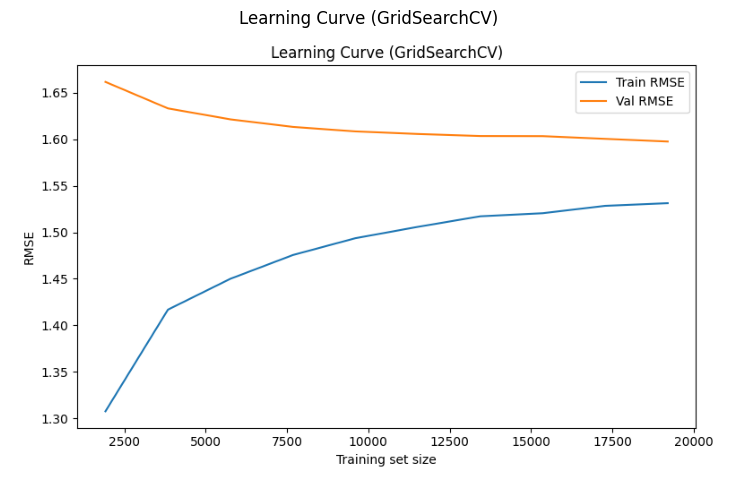

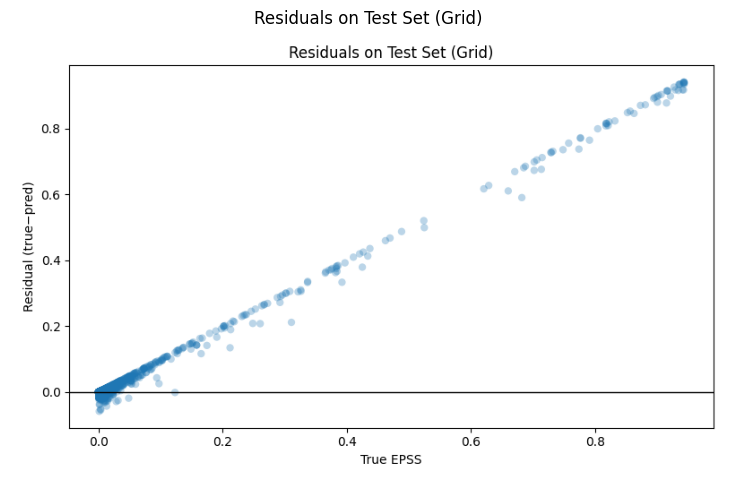

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = [
    ("learning_curve_grid.png", "Learning Curve (GridSearchCV)"),
    ("residuals_grid.png",     "Residuals on Test Set (Grid)")
]

for fname, title in plots:
    # load image
    img = mpimg.imread(fname)
    # display
    plt.figure(figsize=(8,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()


TPE

In [ ]:
# ========== TPE Hyperparameter Optimization ==========
import optuna
from optuna.samplers import TPESampler

print("\n[5-TPE] Starting TPE optimization...")

y_tr = y_tr.reset_index(drop=True)

def objective(trial):
    params = {
        "max_depth":        trial.suggest_int("max_depth", 3, 8),
        "learning_rate":    trial.suggest_float("learning_rate", 1e-2, 1e-1, log=True),
    }

    model = XGBRegressor(**params)
    scores = []
    from sklearn.model_selection import KFold

    cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
    for train_idx, valid_idx in cv.split(X_tr_s):
        model.fit(X_tr_s[train_idx], y_tr[train_idx])
        preds = model.predict(X_tr_s[valid_idx])
        score = mean_squared_error(y_tr[valid_idx], preds)
        scores.append(score)
    return np.mean(scores)

tpe_start = time.perf_counter()

study = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=SEED),
    study_name="xgb_tpe_study"
)

study.optimize(objective, timeout=TIMEOUT, n_trials=100, show_progress_bar=True)

tpe_end = time.perf_counter()
print(f"[5-TPE] TPE done in {tpe_end - tpe_start:.1f}s")
print(f"[5-TPE] Best params: {study.best_params}")

# Save model
tpe_model = XGBRegressor(**study.best_params)
tpe_model.fit(X_tr_s, y_tr)
joblib.dump(tpe_model, "xgb_tpe_model.joblib")

# Replace this with whatever filename you want to write to
with open("results_tpe.txt", "w") as out:
    def report(name, Xs, ys, df_=None):
        y_log = tpe_model.predict(Xs)
        y_pred= expit(y_log)
        y_true= expit(ys)
        mse   = mean_squared_error(y_true, y_pred)
        rmse  = np.sqrt(mse)
        mae   = mean_absolute_error(y_true, y_pred)
        r2    = r2_score(y_true, y_pred)
        out.write(f"{name:5s} → MSE={mse:.6f}, RMSE={rmse:.6f}, "
                  f"MAE={mae:.6f}, R²={r2:.3f}\n")
        print(f"{name:5s} → MSE={mse:.6f}, RMSE={rmse:.6f}, "
              f"MAE={mae:.6f}, R²={r2:.3f}")
        if df_ is not None:
            df_ = df_.copy()
            df_["pred"] = y_pred
            df_["actual"] = y_true
            mean_diff = np.mean(df_["actual"] - df_["pred"])
            out.write(f"       Mean(actual−pred) = {mean_diff:.6f}\n")
            print(f"       Mean(actual−pred) = {mean_diff:.6f}\n")

    out.write("—— Overall performance (TPE) ——\n")
    print("\n[6-TPE] Overall performance:")
    report("TRAIN", X_tr_s, y_tr)
    report("VAL",   X_val_s, y_val)
    report("TEST",  X_te_s, y_te,   df_test)


[I 2025-06-12 16:20:01,438] A new study created in memory with name: xgb_tpe_study



[5-TPE] Starting TPE optimization...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-12 16:20:12,161] Trial 0 finished with value: 2.2967308558629833 and parameters: {'max_depth': 5, 'learning_rate': 0.08927180304353628}. Best is trial 0 with value: 2.2967308558629833.
[I 2025-06-12 16:20:41,144] Trial 1 finished with value: 2.3016414159197063 and parameters: {'max_depth': 7, 'learning_rate': 0.03968793330444373}. Best is trial 0 with value: 2.2967308558629833.
[I 2025-06-12 16:20:46,026] Trial 2 finished with value: 2.9495199549483213 and parameters: {'max_depth': 3, 'learning_rate': 0.01432169828911152}. Best is trial 0 with value: 2.2967308558629833.
[I 2025-06-12 16:20:49,874] Trial 3 finished with value: 2.493756823559962 and parameters: {'max_depth': 3, 'learning_rate': 0.07348118405270448}. Best is trial 0 with value: 2.2967308558629833.
[I 2025-06-12 16:21:08,626] Trial 4 finished with value: 2.3088838848776034 and parameters: {'max_depth': 6, 'learning_rate': 0.051059032093947576}. Best is trial 0 with value: 2.2967308558629833.
[I 2025-06-12 16:21: